# Task 1: Feature Detective 🕵️‍♀️
Analyzing which features are most important for Titanic survival prediction by removing them one by one.


In [5]:
import os
print(os.getcwd())

d:\AIEngineering-8\Milzon\notebooks


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df = pd.read_csv('../data/train.csv')
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 

In [9]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


In [10]:
features = ['Pclass', 'Sex', 'Age', 'FamilySize']
y = df['Survived']


### Baseline Logistic Regression Model with Data Cleaning

In this section, we'll train a baseline Logistic Regression model using the Titanic dataset.  
Before training, we'll ensure all categorical features are encoded numerically and missing values are handled appropriately.


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load data
df = pd.read_csv('../data/train.csv')

# Feature engineering
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Select features and target
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']  # Modify as needed
X = df[features].copy()      # <<-- Tambah .copy() DI SINI!
y = df['Survived']

# Encode categorical features (Sex)
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Handle missing values
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f"Baseline Logistic Regression Accuracy: {baseline_acc:.3f}")


Baseline Logistic Regression Accuracy: 0.804


### Data Preparation & Baseline Logistic Regression (Best Practice)

In this step, we prepare the Titanic dataset for modeling and train a baseline Logistic Regression classifier.  
Key best practices are applied to avoid warnings and ensure reproducibility:

- **Feature Engineering:** We create a new feature `FamilySize` by combining `SibSp`, `Parch`, and the passenger themselves.
- **Feature Selection:** We select a subset of relevant features for prediction.
- **Safe Data Slicing:** We use `.copy()` when creating `X` to avoid the `SettingWithCopyWarning` and keep our original dataframe intact.
- **Categorical Encoding:** We convert the `Sex` column to numeric values for model compatibility.
- **Missing Value Handling:** We fill missing values in `Age` and `Fare` using the median.
- **Train-Test Split:** We split the data for model validation.
- **Model Training:** We fit a baseline Logistic Regression model and check its accuracy.

> **Note:** Using `.copy()` when subsetting features is a standard pandas best practice to prevent unintended side effects or warnings.

The following cell implements all of the above.


**Baseline Accuracy:** This is the accuracy when all main features are included in the model.


In [15]:
# Remove each feature one by one
results = []
for remove_feature in features:
    selected = [f for f in features if f != remove_feature]
    X = df[selected].copy()  # pakai .copy() supaya aman

    # Encode categorical features if present
    if 'Sex' in selected:
        X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
    if 'Embarked' in selected:
        X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
        X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})  # contoh mapping

    # Fill missing values (untuk numerik)
    for col in ['Age', 'Fare']:
        if col in selected:
            X[col] = X[col].fillna(X[col].median())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Removed': remove_feature, 'Accuracy': acc})



#### One-by-One Feature Removal Loop: Checking Feature Importance

In this workflow, we analyze the importance of each feature by systematically removing one feature at a time and observing how the model accuracy changes.

**Process Overview:**
1. **Loop through each feature:** For every feature in our selected list, we create a new subset of data without that feature.
2. **Safe slicing:** We use `.copy()` to avoid pandas warnings and accidental data modification.
3. **Categorical encoding:** After selecting features, we encode any categorical columns (e.g., `Sex`, `Embarked`) to numeric values, since logistic regression requires numbers.
4. **Missing value imputation:** For each subset, we fill missing values (e.g., in `Age`, `Fare`, `Embarked`) to ensure the model receives complete data.
5. **Train-test split:** We split each cleaned subset into training and test data.
6. **Model training and evaluation:** We fit a Logistic Regression model and record the accuracy for each experiment.
7. **Result analysis:** By comparing accuracies, we see which features are critical. If removing a feature significantly reduces accuracy, it's likely important for prediction.

> **Note:** Data cleaning (encoding, imputing) must be repeated after every new feature selection, because slicing from the original dataframe resets everything to its raw form.


keypoint is : Slice → Encode → Impute → Split → Train → Evaluate → Repeat

**Table:** Accuracy after removing each feature, compared to baseline.
- The largest drop in accuracy shows which feature is most important.


**Insight & Answers:**
- Which feature removal hurt accuracy the most? (See largest drop.)
  - "When we remove the feature Sex, the model accuracy drops the most (from 0.80 to 0.66)."
  - Insight:
This means the Sex (gender) feature is highly predictive of survival on the Titanic.

- Which feature seems least important? (Smallest drop.)
  - Removing Parch or SibSp leads to almost no change in accuracy (remains at ~0.80)
  - Insight:
This suggests that the number of siblings/spouses or parents/children on board was not a strong predictor of survival compared to other features.
- Why is gender or class so important?  
  Example: "During the Titanic disaster, women and children were prioritized for rescue. Passenger class often determined access to lifeboats."
  - Class (Pclass):
"Passenger class determined access to lifeboats and cabins closer to the upper decks. First-class passengers were more likely to survive because they had better access to safety equipment and crew assistance."

- Summary Insight:
Both gender and passenger class are not just statistical features—they reflect real-world social policies and inequalities that directly affected survival rates during the Titanic tragedy.


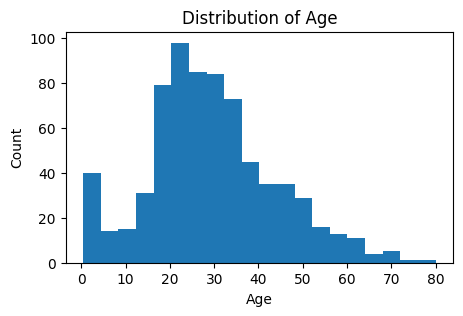

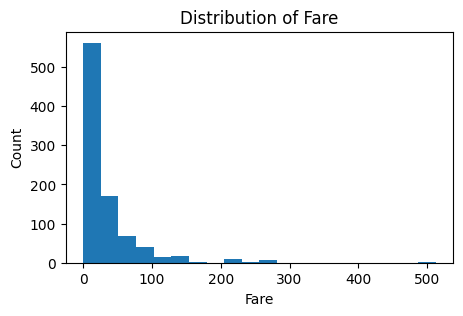

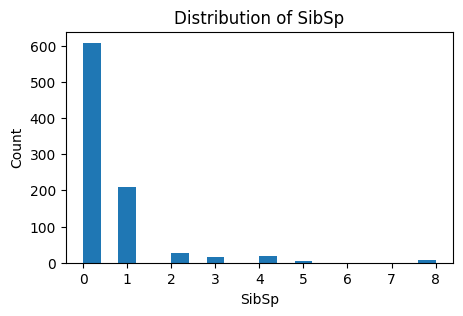

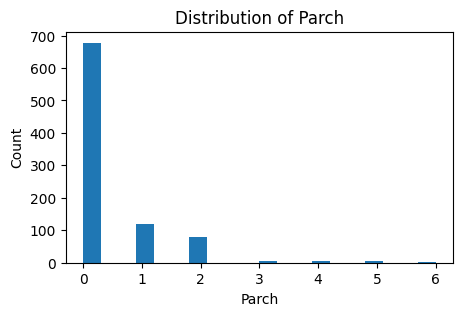

In [16]:
import matplotlib.pyplot as plt

num_features = ['Age', 'Fare', 'SibSp', 'Parch']
for col in num_features:
    plt.figure(figsize=(5,3))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


#### Distribution of Age

![Distribution of Age](../images/detective_distribution age.png)

Most passengers are in their 20s and 30s, but there is a significant number of children and young adults as well. The distribution is right-skewed, showing fewer older passengers. This age pattern may influence survival chances, as both very young and older passengers could have different risks and priorities during a disaster.


#### Distribution of Fare

![Distribution of Fare](../images/detective_distribution fare.png)

Most passengers paid a relatively low fare, while only a small number paid very high fares. The distribution is heavily right-skewed, indicating a large gap between lower and upper-class ticket prices. Fare is often correlated with passenger class, which in turn can affect access to lifeboats and survival rates.


#### Distribution of Parch

![Distribution of Parch](../images/detective_distribution parch.png)

The majority of passengers were traveling without parents or children (`Parch = 0`). Only a small proportion had 1–2 family members with them, and very few had larger groups. This indicates that most people on board were either traveling alone or with a spouse, not with large families.


#### Distribution of SibSp

![Distribution of SibSp](../images/detective_distribution SibSp.png)

Most passengers were traveling without siblings or spouses (`SibSp = 0`). Some had one or two, but higher numbers are rare. This feature helps us understand the family structures among passengers, which might influence survival behavior and group decisions.
